## 📊 Passing Performance & Expected Pass (xP) Analysis in Women’s Football

**Purpose:** Evaluate and improve Expected Pass (xP) model reliability through probability calibration, and analyse player passing performance using the calibrated metric. The analysis compares pass difficulty with actual completion to assess how players perform relative to expectation.  
**Competitions:** Women’s club and international competitions available in StatsBomb Open Data, with particular emphasis on the UEFA Women’s Euro and FIFA Women’s World Cup  
**Data Sources:** Event data, match metadata, and lineup information from StatsBomb Open Data  
**Methods:** Probability calibration (isotonic regression), model evaluation across competitions, player–competition level aggregation, pass outcome comparison (completed vs expected), and contextual role analysis using match lineups  
**Author:**  [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/)   

**Related Work:**  
[Building Expected Passes xP for Womens Football](https://github.com/vickyfriss/Football-analytics/blob/main/202601%20-%202%20-%20Building%20Expected%20Passes%20xP%20for%20Womens%20Football.ipynb)  
[Pass Completion Isn’t Pass Quality – Building Expected Passes (xP) for Women’s Football](https://medium.com/@vickyfrissdekereki/pass-completion-isnt-pass-quality-building-expected-passes-xp-for-women-s-football-84af2e9cd67f)  
[Building an Expected Passes (xP) Model for Women’s Football in Python](https://medium.com/@vickyfrissdekereki/building-an-expected-passes-xp-model-for-womens-football-in-python-5068a4be6f0d)  

**Medium Articles:**  
[Expected Pass (xP) in Women’s Football: How to Calibrate Pass Predictions for Accuracy](https://medium.com/@vickyfrissdekereki/expected-pass-xp-in-womens-football-how-to-calibrate-pass-predictions-for-accuracy-ad87d16f0da3)     

---

**Notebook first written:** `14/02/2026`  
**Last updated:** `16/02/2026`  

> This notebook calibrates Expected Pass (xP) predictions to improve probability accuracy across competitions, and uses the calibrated values to analyse player passing performance.  
>  
> Passing behaviour is examined by player and competition — especially major international tournaments — and contextualised using lineup data to understand how player roles and positioning relate to passing performance under different competitive environments


-------------------------

In [1]:
import os  # Interact with the operating system (file paths, directories, etc.)
import warnings  # Control warning messages in Python

import numpy as np  # Numerical computing (arrays, math operations)
import pandas as pd  # Data manipulation and analysis (DataFrames)

from sklearn.isotonic import IsotonicRegression  # Probability calibration using isotonic regression
from sklearn.linear_model import LogisticRegression, LinearRegression  # Logistic and linear regression models

import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns  # Statistical data visualisation built on matplotlib

from IPython.display import display, Markdown  # Display rich outputs in notebooks (tables, formatted text)

from statsbombpy.api_client import NoAuthWarning  # Warning class for StatsBomb API without authentication
warnings.filterwarnings("ignore", category=NoAuthWarning)  # Suppress StatsBomb no-auth warnings

from statsbombpy import sb  # StatsBomb data access (matches, events, competitions)

# 1. Load datasets created in previous work

In [2]:
data_folder = r"C:\Users\vicky\Desktop\Football-analytics\Datasets\xP_master"

# Dictionary to hold each DataFrame
dfs = {}

# Load each file
for filename in os.listdir(data_folder):
    if filename.endswith(".parquet"):
        full_path = os.path.join(data_folder, filename)
        dfs[filename] = pd.read_parquet(full_path)
        print(f"Loaded {filename} with shape {dfs[filename].shape}")

# Access individual DataFrames, for example:
competitions_df = dfs['competitions.parquet']
matches_df = dfs['matches.parquet']
model_features_df = dfs['model_features_X.parquet']
passes_xp_df = dfs['passes_features_with_xp.parquet']
passes_raw_df = dfs['passes_raw.parquet']

Loaded competitions.parquet with shape (8, 12)
Loaded matches.parquet with shape (540, 22)
Loaded model_features_X.parquet with shape (495781, 213)
Loaded passes_features_with_xp.parquet with shape (495781, 349)
Loaded passes_raw.parquet with shape (496100, 122)


In [3]:
passes_xp_df.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,pp_From Counter,pp_From Free Kick,pp_From Goal Kick,pp_From Keeper,pp_From Kick Off,pp_From Throw In,pp_Other,pp_Regular Play,completed,xP
0,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.769447
1,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.982276
2,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.952742
3,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.753151
4,None,None,None,None,None,None,None,None,None,None,...,False,False,False,False,True,False,False,False,1,0.811358


In [4]:
len(passes_xp_df)

495781

In [5]:
matches_df.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3775648,2021-02-28,15:00:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Arsenal WFC,0,4,available,...,2021-06-13T16:17:31.694,11,Regular Season,Poundland Bescot Stadium,Lisa Benn,Marcus Bignot,Joseph Montemurro,1.1.0,2,2
1,3775609,2021-04-28,20:30:00.000,England - FA Women's Super League,2020/2021,Arsenal WFC,West Ham United LFC,2,0,available,...,2021-06-13T16:17:31.694,13,Regular Season,Meadow Park,Emily Heaslip,Joseph Montemurro,Olli Harder,1.1.0,2,2
2,3775633,2021-02-06,13:30:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Tottenham Hotspur Women,1,0,available,...,2021-06-13T16:17:31.694,14,Regular Season,Poundland Bescot Stadium,Jane Simms,Marcus Bignot,Rehanne Skinner,1.1.0,2,2
3,3775570,2021-03-28,13:30:00.000,England - FA Women's Super League,2020/2021,Brighton & Hove Albion WFC,Everton LFC,0,5,available,...,2021-06-13T16:17:31.694,18,Regular Season,Broadfield Stadium,Christina Hattersley,Hope Patricia Powell,Willie Kirk,1.1.0,2,2
4,3775581,2021-03-28,15:30:00.000,England - FA Women's Super League,2020/2021,Chelsea FCW,Aston Villa,2,0,available,...,2021-06-13T16:17:31.694,18,Regular Season,Kingsmeadow,Sarah Garratt,Emma Hayes,Marcus Bignot,1.1.0,2,2


# 2. Calibration

**∑(completed−xP)**

**Interpretation**  

≈ 0 → well calibrated  
The model predicts the right number of successful passes overall.

Positive → model underestimates success  
Players complete more passes than expected.

Negative → model overestimates success  
Model predicts too many successful passes.

### Calibration Summary — All Tournaments

,n_passes,total_completed,total_xP,difference,relative_error,mean_error_per_pass,ci_lower,ci_upper
competition_name,,,,,,,,
England - FA Women's Super League,"298,215.00","219,836.00","220,331.05",-495.05,-0.22%,-0.0017,-889.50,-83.02
Europe - UEFA Women's Euro,"58,344.00","44,843.00","43,885.64",957.36,2.18%,0.0164,784.34,"1,123.36"
International - Women's World Cup,"107,167.00","79,708.00","79,163.88",544.12,0.69%,0.0051,308.98,787.43
United States of America - NWSL,"32,055.00","22,065.00","23,049.78",-984.78,-4.27%,-0.0307,"-1,119.17",-851.31


C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\1134598970.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby('xP_bin').agg(


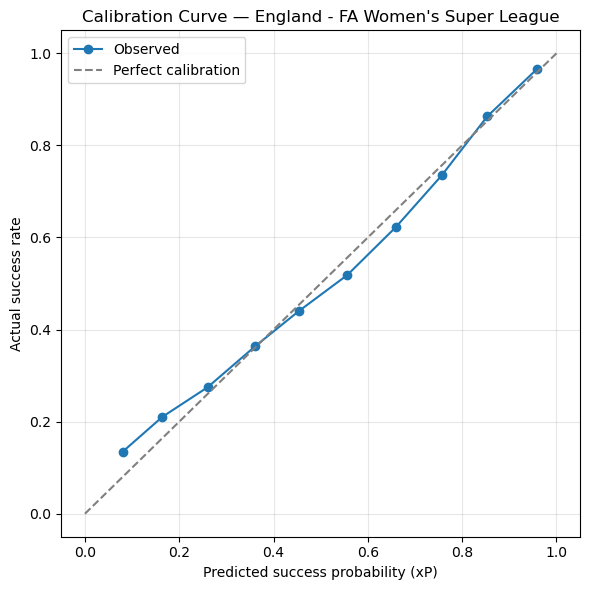

C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\1134598970.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby('xP_bin').agg(


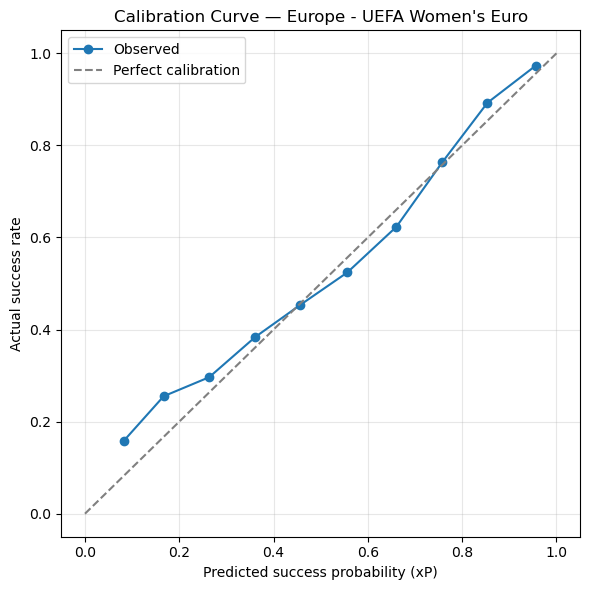

C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\1134598970.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby('xP_bin').agg(


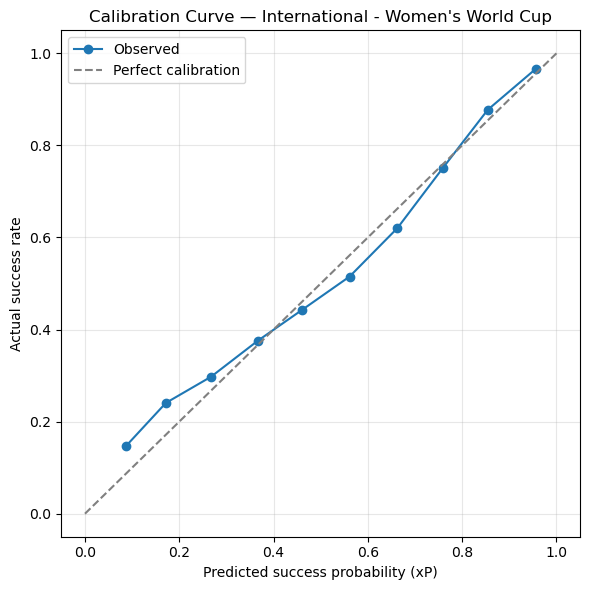

C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\1134598970.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby('xP_bin').agg(


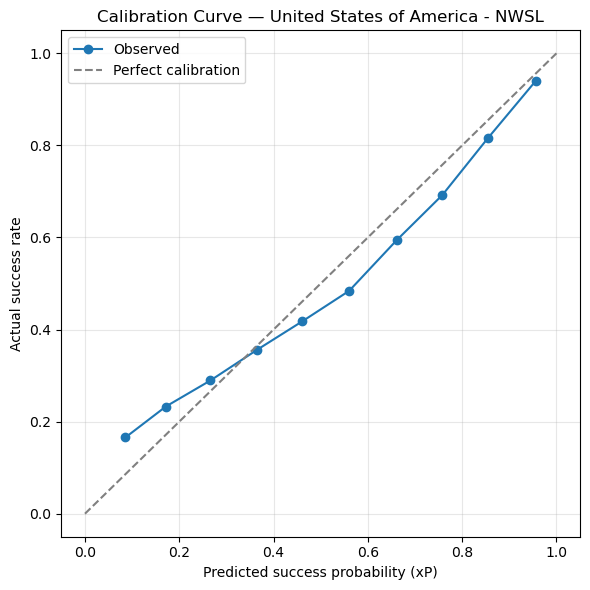

### Calibration — Euros & World Cup

,n_passes,total_completed,total_xP,difference,relative_error,mean_error_per_pass,ci_lower,ci_upper
competition_name,,,,,,,,
Europe - UEFA Women's Euro,"58,344.00","44,843.00","43,885.64",957.36,2.18%,0.0164,784.34,"1,123.36"
International - Women's World Cup,"107,167.00","79,708.00","79,163.88",544.12,0.69%,0.0051,308.98,787.43


In [6]:
# Merge competition info
passes_xp_df = passes_xp_df.merge(
    matches_df[['match_id', 'competition']],
    on='match_id',
    how='left'
)
# Use consistent name
passes_xp_df.rename(columns={'competition':'competition_name'}, inplace=True)


# Calibration summary
calibration_summary = (
    passes_xp_df
    .groupby('competition_name')
    .agg(
        n_passes=('xP', 'size'),
        total_completed=('completed', 'sum'),
        total_xP=('xP', 'sum')
    )
)
calibration_summary['difference'] = calibration_summary['total_completed'] - calibration_summary['total_xP']
calibration_summary['relative_error'] = calibration_summary['difference'] / calibration_summary['total_xP']
calibration_summary['mean_error_per_pass'] = calibration_summary['difference'] / calibration_summary['n_passes']


# Bootstrap confidence intervals
def bootstrap_total_difference(df, n_boot=2000, seed=14):
    rng = np.random.default_rng(seed)
    values = df[['completed', 'xP']].to_numpy()
    diffs = []
    for _ in range(n_boot):
        sample_idx = rng.integers(0, len(values), len(values))
        sample = values[sample_idx]
        diffs.append(sample[:,0].sum() - sample[:,1].sum())
    return np.percentile(diffs, [2.5,97.5])

ci_results = []
for comp, group in passes_xp_df.groupby('competition_name'):
    low, high = bootstrap_total_difference(group)
    ci_results.append({'competition_name': comp, 'ci_lower': low, 'ci_upper': high})

ci_df = pd.DataFrame(ci_results).set_index('competition_name')
calibration_summary = calibration_summary.join(ci_df)


# Display function
def display_calibration_table(df, title):
    formatted = df.copy()
    formatted['relative_error'] = (formatted['relative_error']*100).map("{:.2f}%".format)
    formatted['mean_error_per_pass'] = formatted['mean_error_per_pass'].round(4)
    for col in ['n_passes','total_completed','total_xP','difference','ci_lower','ci_upper']:
        formatted[col] = formatted[col].round(2).map("{:,.2f}".format)
    display(Markdown(f"### {title}"))
    display(formatted)

display_calibration_table(calibration_summary, "Calibration Summary — All Tournaments")


# Calibration curves
def plot_calibration_curve(df, competition, bins=10):
    df = df.copy()
    df['xP_bin'] = pd.cut(df['xP'], bins=bins)
    calib = df.groupby('xP_bin').agg(
        mean_predicted=('xP','mean'),
        actual_success=('completed','mean')
    ).dropna()
    plt.figure(figsize=(6,6))
    plt.plot(calib['mean_predicted'], calib['actual_success'], marker='o', label='Observed')
    plt.plot([0,1],[0,1],'--',color='gray',label='Perfect calibration')
    plt.title(f'Calibration Curve — {competition}')
    plt.xlabel('Predicted success probability (xP)')
    plt.ylabel('Actual success rate')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

for comp, group in passes_xp_df.groupby('competition_name'):
    plot_calibration_curve(group, comp)


# Focused view: Euros & World Cup
target_tournaments = [
    "Europe - UEFA Women's Euro",
    "International - Women's World Cup"
]
focus_summary = calibration_summary.loc[calibration_summary.index.intersection(target_tournaments)]
display_calibration_table(focus_summary, "Calibration — Euros & World Cup")

C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\3833440970.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('xP_bin')
C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\3833440970.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('xP_bin')
C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\3833440970.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('xP_bin')
C:\Users\vicky\AppD

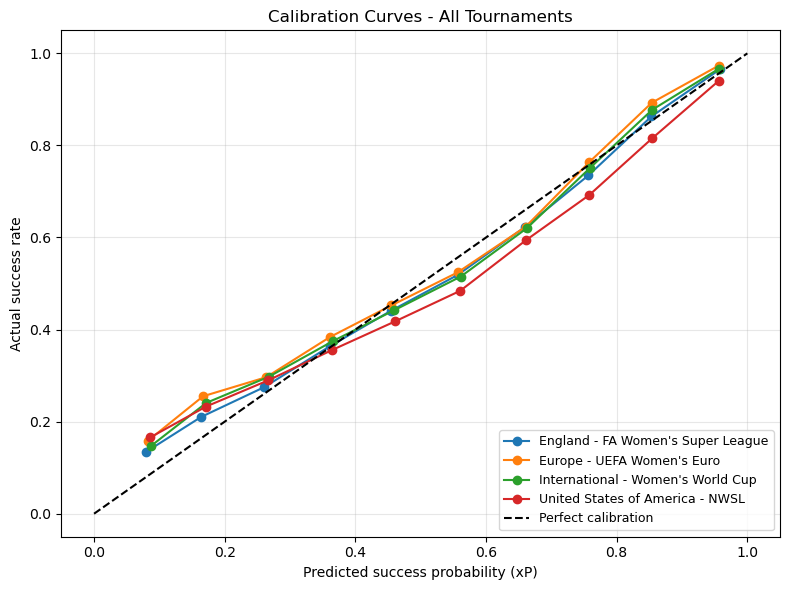

In [7]:
# Combined Calibration Curves — All Tournaments

plt.figure(figsize=(8, 6))
bins = 10

for comp, group in passes_xp_df.groupby('competition_name'):
    df = group.copy()
    df['xP_bin'] = pd.cut(df['xP'], bins=bins)

    calib = (
        df.groupby('xP_bin')
          .agg(mean_predicted=('xP', 'mean'),
               actual_success=('completed', 'mean'))
          .dropna()
    )

    plt.plot(calib['mean_predicted'], calib['actual_success'], marker='o', label=comp)

# Perfect calibration line
plt.plot([0,1],[0,1],'--', color='black', label='Perfect calibration')

plt.title('Calibration Curves - All Tournaments')
plt.xlabel('Predicted success probability (xP)')
plt.ylabel('Actual success rate')
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()

In [8]:
# Linear Scaling

def linear_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    eps = 1e-6
    data["p_clip"] = data[prob_col].clip(eps,1-eps)

    # fit simple linear regression
    model = LinearRegression()
    model.fit(data[["p_clip"]], data[outcome_col])

    a = model.intercept_
    b = model.coef_[0]

    data["xP_linear_calibrated"] = a + b * data["p_clip"]
    # clip to [0,1]
    data["xP_linear_calibrated"] = data["xP_linear_calibrated"].clip(0,1)

    return data, a, b

def plot_linear(df, title):
    df_before = df.copy()
    df_after = df.copy()
    
    bins=10
    df_before["bin"] = pd.cut(df_before["xP"], bins=bins)
    df_after["bin"] = pd.cut(df_after["xP_linear_calibrated"], bins=bins)
    
    before_curve = df_before.groupby("bin").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df_after.groupby("bin").agg(predicted=("xP_linear_calibrated","mean"), actual=("completed","mean")).dropna()
    
    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Linear Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
def show_changes_linear(df,n=10):
    df["abs_change"] = (df["xP_linear_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)

In [9]:
# Logistic Recalibration (Platt scaling in logit space)

def logit(p): return np.log(p/(1-p))
def inv_logit(x): return 1/(1+np.exp(-x))

def logistic_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    eps = 1e-6
    data["p_clip"] = data[prob_col].clip(eps,1-eps)
    data["logit_xp"] = logit(data["p_clip"])

    model = LogisticRegression(solver="lbfgs")
    model.fit(data[["logit_xp"]], data[outcome_col])

    a = model.intercept_[0]
    b = model.coef_[0][0]

    calibrated_logit = a + b*data["logit_xp"]
    data["xP_logistic_calibrated"] = inv_logit(calibrated_logit)

    return data, a, b

def plot_logistic(df, title):
    bins=10
    df["bin_before"] = pd.cut(df["xP"], bins=bins)
    df["bin_after"] = pd.cut(df["xP_logistic_calibrated"], bins=bins)

    before_curve = df.groupby("bin_before").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df.groupby("bin_after").agg(predicted=("xP_logistic_calibrated","mean"), actual=("completed","mean")).dropna()

    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Logistic Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_changes_logistic(df,n=10):
    df["abs_change"] = (df["xP_logistic_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)


In [10]:
# Isotonic Regression (Non-parametric monotone fit)

def isotonic_recalibrate(df, prob_col="xP", outcome_col="completed"):
    data = df.copy()
    iso = IsotonicRegression(out_of_bounds="clip")
    data["xP_iso_calibrated"] = iso.fit_transform(data[prob_col], data[outcome_col])
    return data, iso

def plot_isotonic(df, title):
    bins=10
    df["bin_before"] = pd.cut(df["xP"], bins=bins)
    df["bin_after"] = pd.cut(df["xP_iso_calibrated"], bins=bins)

    before_curve = df.groupby("bin_before").agg(predicted=("xP","mean"), actual=("completed","mean")).dropna()
    after_curve = df.groupby("bin_after").agg(predicted=("xP_iso_calibrated","mean"), actual=("completed","mean")).dropna()

    plt.figure(figsize=(6,6))
    plt.plot(before_curve["predicted"], before_curve["actual"], marker="o", label="Before")
    plt.plot(after_curve["predicted"], after_curve["actual"], marker="o", label="Isotonic Calibrated")
    plt.plot([0,1],[0,1],"--", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual success rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_changes_isotonic(df,n=10):
    df["abs_change"] = (df["xP_iso_calibrated"] - df["xP"]).abs()
    return df.sort_values("abs_change", ascending=False).head(n)

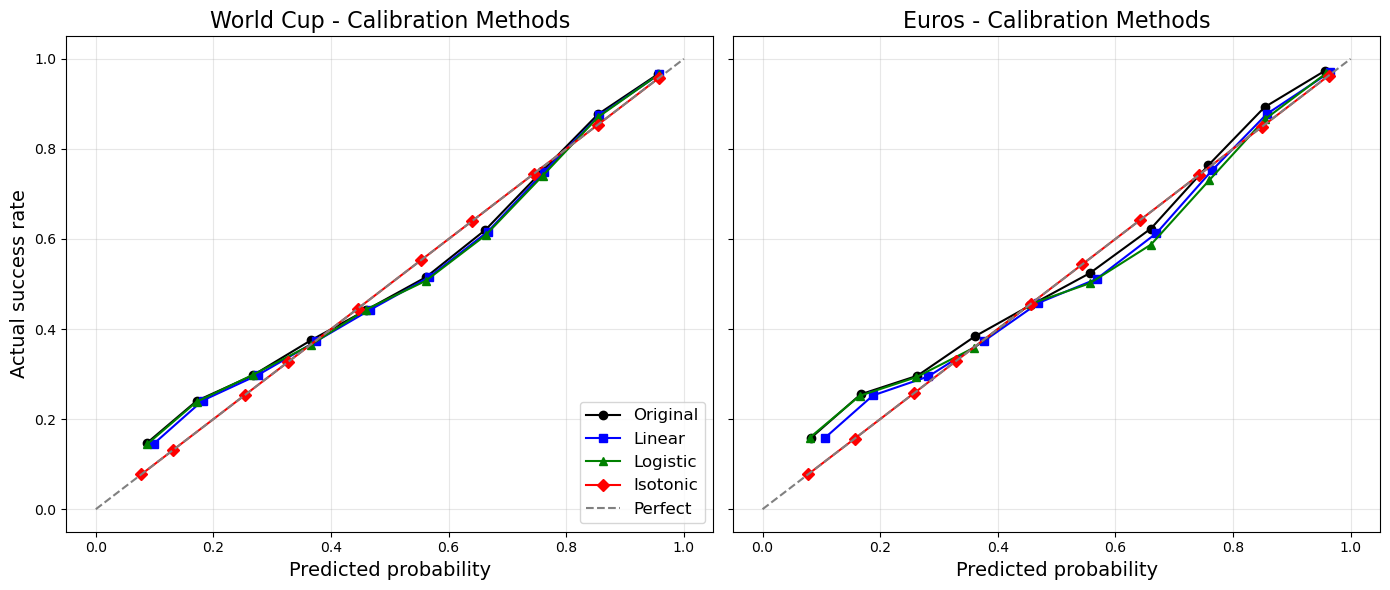

In [11]:
# Function to prepare calibration curves

def get_calibration_curve(df, prob_col, outcome_col="completed", bins=10):
    df_copy = df.copy()
    df_copy["bin"] = pd.cut(df_copy[prob_col], bins=bins)
    
    curve = df_copy.groupby("bin", observed=True).agg(
        predicted=(prob_col, "mean"),
        actual=(outcome_col, "mean")
    ).dropna()
    
    return curve


# Function to plot side by side calibration curves

def plot_side_by_side(df1, df2, methods_dict, titles, bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    markers = {"Original":"o","Linear":"s","Logistic":"^","Isotonic":"D"}
    colors = {"Original":"black","Linear":"blue","Logistic":"green","Isotonic":"red"}

    for ax, df, title in zip(axes, [df1, df2], titles):
        for name, col in methods_dict.items():
            if col not in df.columns:
                continue
            curve = get_calibration_curve(df, col, bins=bins)
            ax.plot(curve["predicted"], curve["actual"], 
                    marker=markers.get(name,"o"), 
                    label=name, color=colors.get(name,"gray"))
        # Perfect calibration line
        ax.plot([0,1],[0,1],"--", color="gray", label="Perfect")
        ax.set_xlabel("Predicted probability", fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.grid(alpha=0.3)
    
    axes[0].set_ylabel("Actual success rate", fontsize=14)
    axes[0].legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.show()

# Prepare datasets for both tournaments
worldcup = passes_xp_df[passes_xp_df["competition_name"]=="International - Women's World Cup"].copy()
euros     = passes_xp_df[passes_xp_df["competition_name"]=="Europe - UEFA Women's Euro"].copy()

# Apply the three calibrations
# World Cup
wc_linear, _, _ = linear_recalibrate(worldcup)
wc_log, _, _ = logistic_recalibrate(worldcup)
wc_iso, _ = isotonic_recalibrate(worldcup)

worldcup_all = worldcup.copy()
worldcup_all["xP_linear"] = wc_linear["xP_linear_calibrated"]
worldcup_all["xP_logistic"] = wc_log["xP_logistic_calibrated"]
worldcup_all["xP_isotonic"] = wc_iso["xP_iso_calibrated"]

# Euros
euros_linear, _, _ = linear_recalibrate(euros)
euros_log, _, _ = logistic_recalibrate(euros)
euros_iso, _ = isotonic_recalibrate(euros)

euros_all = euros.copy()
euros_all["xP_linear"] = euros_linear["xP_linear_calibrated"]
euros_all["xP_logistic"] = euros_log["xP_logistic_calibrated"]
euros_all["xP_isotonic"] = euros_iso["xP_iso_calibrated"]


# Plot all methods side by side
methods = {
    "Original": "xP",
    "Linear": "xP_linear",
    "Logistic": "xP_logistic",
    "Isotonic": "xP_isotonic"
}

plot_side_by_side(
    worldcup_all, 
    euros_all, 
    methods, 
    titles=["World Cup - Calibration Methods", "Euros - Calibration Methods"]
)

In [12]:
# Show top 5 most changed passes with match info and completed column
def top_changed_passes_with_completed(df, matches_df, n=5):
    df = df.copy()
    
    # Compute absolute change per method
    df["abs_change_linear"] = (df["xP_linear"] - df["xP"]).abs()
    df["abs_change_logistic"] = (df["xP_logistic"] - df["xP"]).abs()
    df["abs_change_isotonic"] = (df["xP_isotonic"] - df["xP"]).abs()
    
    # Max change across methods
    df["max_change"] = df[["abs_change_linear","abs_change_logistic","abs_change_isotonic"]].max(axis=1)
    
    # Merge match-level info
    match_cols = [
        "match_id", "match_date", "kick_off", "competition", "season",
        "home_team", "away_team", "home_score", "away_score"
    ]
    df = df.merge(matches_df[match_cols], on="match_id", how="left")
    
    # Columns to display — include 'completed'
    cols = [
        "match_id","match_date","kick_off","competition","season",
        "home_team","away_team","home_score","away_score",
        "team","player","minute","second","completed",
        "xP","xP_linear","xP_logistic","xP_isotonic","max_change"
    ]
    available_cols = [c for c in cols if c in df.columns]
    
    # Top N most changed
    top_df = df.sort_values("max_change", ascending=False).head(n)
    return top_df[available_cols]

# World Cup — top 5 changed passes
worldcup_top5_completed = top_changed_passes_with_completed(worldcup_all, matches_df, 5)
display(worldcup_top5_completed)

# Euros — top 5 changed passes
euros_top5_completed = top_changed_passes_with_completed(euros_all, matches_df, 5)
display(euros_top5_completed)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,team,player,minute,second,completed,xP,xP_linear,xP_logistic,xP_isotonic,max_change
98114,68338,2019-06-19,21:00:00.000,International - Women's World Cup,2019,Scotland Women's,Argentina Women's,3,3,Argentina Women's,María Florencia Bonsegundo,16,29,1,0.114176,0.124971,0.114736,0.232681,0.118505
9800,3901832,2023-08-08,11:00:00.000,International - Women's World Cup,2023,Colombia Women's,Jamaica Women's,1,0,Colombia Women's,Ana María Guzmán Zapata,50,48,1,0.114184,0.124979,0.114745,0.232681,0.118497
92214,69202,2019-06-28,21:00:00.000,International - Women's World Cup,2019,France Women's,United States Women's,1,2,France Women's,Eugénie Le Sommer,61,27,0,0.114189,0.124984,0.114750,0.232681,0.118492
9991,3901832,2023-08-08,11:00:00.000,International - Women's World Cup,2023,Colombia Women's,Jamaica Women's,1,0,Jamaica Women's,Chantelle Swaby,74,39,0,0.114197,0.124991,0.114757,0.232681,0.118484
19454,3901736,2023-08-07,13:30:00.000,International - Women's World Cup,2023,Australia Women's,Denmark Women's,2,0,Australia Women's,Ellie Madison Carpenter,18,39,0,0.114198,0.124993,0.114759,0.232681,0.118482


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,team,player,minute,second,completed,xP,xP_linear,xP_logistic,xP_isotonic,max_change
45769,3835329,2022-07-12,18:00:00.000,Europe - UEFA Women's Euro,2022,Denmark Women's,WNT Finland,1,0,Denmark Women's,Janni Thomsen,17,2,1,0.095536,0.119145,0.093453,0.210654,0.115118
50722,3835341,2022-07-18,21:00:00.000,Europe - UEFA Women's Euro,2022,Italy Women's,Belgium Women's,0,1,Italy Women's,Barbara Bonansea,46,58,0,0.095628,0.119236,0.093548,0.210654,0.115025
21657,3998845,2025-07-06,16:00:00.000,Europe - UEFA Women's Euro,2025,Norway Women's,WNT Finland,2,1,Norway Women's,Cecilie Fiskerstrand,44,19,0,0.095670,0.119277,0.093591,0.210654,0.114984
9201,3998859,2025-07-13,19:00:00.000,Europe - UEFA Women's Euro,2025,Netherlands Women's,France Women's,2,5,Netherlands Women's,Dominique Johanna Anna Petrone Janssen,59,10,0,0.095832,0.119438,0.093758,0.210654,0.114822
19440,3998847,2025-07-07,16:00:00.000,Europe - UEFA Women's Euro,2025,Spain Women's,Belgium Women's,6,2,Belgium Women's,Janice Cayman,6,24,1,0.095898,0.119503,0.093826,0.210654,0.114756


In [13]:
# Get completed passes from the Women's World Cup final
def get_wc_final_completed_passes(df, matches_df, n=1):
    # Filter World Cup matches
    wc_matches = matches_df[matches_df["competition"] == "International - Women's World Cup"]
    
    if wc_matches.empty:
        print("No World Cup matches found.")
        return None
    
    # Assume the final is the last match by date
    final_match = wc_matches.sort_values("match_date", ascending=True).iloc[-1]
    match_id = final_match["match_id"]
    
    # Filter passes in that match
    df_match = df[(df["match_id"] == match_id) & (df["completed"] == True)].copy()
    
    if df_match.empty:
        print("No completed passes found for the World Cup final match.")
        return None
    
    # Compute max change per pass (if not already present)
    for method in ["linear", "logistic", "isotonic"]:
        abs_col = f"abs_change_{method}"
        if abs_col not in df_match.columns:
            df_match[abs_col] = (df_match[f"xP_{method}"] - df_match["xP"]).abs()
    
    df_match["max_change"] = df_match[["abs_change_linear","abs_change_logistic","abs_change_isotonic"]].max(axis=1)
    
    # Pick top N passes with biggest recalibration
    example_passes = df_match.sort_values("max_change", ascending=False).head(n)
    
    # Columns to show
    cols = [
        "match_id","match_date","kick_off","competition","season",
        "home_team","away_team","home_score","away_score",
        "team","player","minute","second","completed",
        "xP","xP_linear","xP_logistic","xP_isotonic","max_change"
    ]
    available_cols = [c for c in cols if c in example_passes.columns]
    
    return example_passes[available_cols]

# Get top 10 completed passes from the World Cup final
wc_final_completed_passes = get_wc_final_completed_passes(worldcup_all, matches_df, n=10)
display(wc_final_completed_passes)

,match_id,team,player,minute,second,completed,xP,xP_linear,xP_logistic,xP_isotonic,max_change
390271,3906390,Spain Women's,Catalina Thomas Coll Lluch,74,11,1,0.124738,0.135436,0.125471,0.232681,0.107943
389576,3906390,Spain Women's,Aitana Bonmati Conca,5,42,1,0.212436,0.222331,0.214812,0.284523,0.072088
390024,3906390,Spain Women's,Ona Batlle Pascual,45,21,1,0.161291,0.171654,0.162675,0.232681,0.071390
390429,3906390,Spain Women's,Ona Batlle Pascual,101,24,1,0.213169,0.223058,0.215561,0.284523,0.071354
390081,3906390,Spain Women's,Jennifer Hermoso Fuentes,49,2,1,0.546380,0.553218,0.554203,0.475831,0.070549
390435,3906390,England Women's,Lucy Bronze,102,46,1,0.214525,0.224401,0.216944,0.284523,0.069998
389673,3906390,England Women's,Rachel Daly,15,10,1,0.545159,0.552008,0.552972,0.475831,0.069328
390162,3906390,England Women's,Keira Walsh,57,0,1,0.543496,0.550360,0.551294,0.475831,0.067665
389693,3906390,Spain Women's,Olga Carmona García,16,46,1,0.216998,0.226852,0.219466,0.284523,0.067525
390157,3906390,Spain Women's,Olga Carmona García,56,37,1,0.217459,0.227308,0.219935,0.284523,0.067065


In [14]:
def mean_absolute_calibration_error_binned(df, prob_cols, outcome_col="completed", bins=10):
    mae_dict = {}
    for col in prob_cols:
        curve = get_calibration_curve(df, col, outcome_col, bins=bins)
        mae = np.mean(np.abs(curve["predicted"] - curve["actual"]))
        mae_dict[col] = mae
    return mae_dict

# Compute binned MAE
prob_cols = ["xP", "xP_linear", "xP_logistic", "xP_isotonic"]

worldcup_mae_binned = mean_absolute_calibration_error_binned(worldcup_all, prob_cols)
euros_mae_binned = mean_absolute_calibration_error_binned(euros_all, prob_cols)

print("World Cup binned MAE:", worldcup_mae_binned)
print("UEFA Euro binned MAE:", euros_mae_binned)

World Cup binned MAE: {'xP': 0.03154229622967869, 'xP_linear': 0.029441941911509357, 'xP_logistic': 0.03246361657719744, 'xP_isotonic': 3.3306690738754695e-17}
UEFA Euro binned MAE: {'xP': 0.03542270425731729, 'xP_linear': 0.029554432303678248, 'xP_logistic': 0.03759506447075917, 'xP_isotonic': 0.0}


In [15]:
euros_all.head(2)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,pp_From Kick Off,pp_From Throw In,pp_Other,pp_Regular Play,completed,xP,competition_name,xP_linear,xP_logistic,xP_isotonic
330270,None,None,None,None,None,None,None,None,None,None,...,True,False,False,False,1,0.999118,Europe - UEFA Women's Euro,1.000000,0.999436,0.996358
330271,None,None,None,None,None,None,None,None,None,None,...,True,False,False,False,1,0.072978,Europe - UEFA Women's Euro,0.096834,0.070362,0.156522


In [16]:
worldcup_all.head(2)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,pp_From Kick Off,pp_From Throw In,pp_Other,pp_Regular Play,completed,xP,competition_name,xP_linear,xP_logistic,xP_isotonic
388614,None,None,None,None,None,None,None,None,None,None,...,True,False,False,False,1,0.941125,International - Women's World Cup,0.944349,0.944457,0.950411
388615,None,None,None,None,None,None,None,None,None,None,...,True,False,False,False,1,0.991295,International - Women's World Cup,0.994060,0.991996,0.989211


# 3. Download lineups from Statsbomb API to get player positions

In [19]:
# File path to cache the lineups

base_folder = "Datasets/Women's football xP"
filename = "womens_football_lineups.pkl"
full_path = os.path.join(base_folder, filename)

# Make sure the directory exists
os.makedirs(base_folder, exist_ok=True)


# Load from cache if exists

if os.path.exists(full_path):
    print(f"Loading cached lineups from {full_path}...")
    lineups_df = pd.read_pickle(full_path)


# Otherwise download & save

else:
    print("Cached lineups not found → downloading from StatsBomb API...")

    all_lineups = []
    match_ids = matches_df['match_id'].dropna().unique()
    total_matches = len(match_ids)

    for i, match_id in enumerate(match_ids, start=1):

        try:
            lineups = sb.lineups(match_id=match_id)

            # statsbombpy returns one dataframe per team → stack them
            for team, df in lineups.items():
                df = df.copy()
                df['team_name'] = team
                df['match_id'] = match_id
                all_lineups.append(df)

            print(f"Downloaded {i}/{total_matches} matches", end="\r")

        except Exception as e:
            print(f"\nCould not load lineup for match {match_id}: {e}")

    # Combine all matches
    lineups_df = pd.concat(all_lineups, ignore_index=True)

    # Extract position from the nested "positions" list
    def extract_primary_position(pos_list):
        if isinstance(pos_list, list) and len(pos_list) > 0:
            return pos_list[0].get('position')
        return None

    lineups_df['position'] = lineups_df['positions'].apply(extract_primary_position)

    # Clean up columns
    lineups_df = lineups_df.rename(columns={'player_name': 'player'})
    lineups_df = lineups_df[['match_id', 'player', 'player_id', 'team_name', 'position']]

    # Add competition/tournament info
    match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
    lineups_df['competition_name'] = lineups_df['match_id'].map(match_to_competition)

    lineups_df = lineups_df[
        ['match_id', 'competition_name', 'player', 'player_id', 'team_name', 'position']
    ]

    # Save to disk for future use
    print(f"\nSaving cached lineups to {full_path} ...")
    lineups_df.to_pickle(full_path)

    print("Saved successfully!")

print(f"\nFinished. Total matches processed: {len(lineups_df['match_id'].unique())}")
lineups_df.head()

Loading cached lineups from Datasets/Women's football xP\womens_football_lineups.pkl...

Finished. Total matches processed: 540


,match_id,competition_name,player,player_id,team_name,position
0,3775648,England - FA Women's Super League,Anita Amma Ankyewah Asante,4657,Aston Villa,Center Back
1,3775648,England - FA Women's Super League,Stine Larsen,10102,Aston Villa,Left Center Forward
2,3775648,England - FA Women's Super League,Chloe Arthur,10193,Aston Villa,Left Center Midfield
3,3775648,England - FA Women's Super League,Emma Follis,15557,Aston Villa,Right Center Forward
4,3775648,England - FA Women's Super League,Marisa Ewers,15565,Aston Villa,Center Defensive Midfield


In [20]:
# list all unique positions
all_positions = sorted(lineups_df['position'].dropna().unique())

print("All positions in dataset:")
for p in all_positions:
    print(p)

All positions in dataset:
Center Attacking Midfield
Center Back
Center Defensive Midfield
Center Forward
Center Midfield
Goalkeeper
Left Attacking Midfield
Left Back
Left Center Back
Left Center Forward
Left Center Midfield
Left Defensive Midfield
Left Midfield
Left Wing
Left Wing Back
Right Attacking Midfield
Right Back
Right Center Back
Right Center Forward
Right Center Midfield
Right Defensive Midfield
Right Midfield
Right Wing
Right Wing Back
Secondary Striker


In [21]:
# Map detailed StatsBomb positions into 4 main categories
position_map = {
    # goalkeeper
    "Goalkeeper": "Goalkeeper",

    # defenders (including wing backs)
    "Center Back": "Defender",
    "Left Back": "Defender",
    "Right Back": "Defender",
    "Left Center Back": "Defender",
    "Right Center Back": "Defender",
    "Left Wing Back": "Defender",
    "Right Wing Back": "Defender",

    # midfield (defensive / central / attacking / wide)
    "Center Midfield": "Midfielder",
    "Left Center Midfield": "Midfielder",
    "Right Center Midfield": "Midfielder",
    "Left Midfield": "Midfielder",
    "Right Midfield": "Midfielder",
    "Center Defensive Midfield": "Midfielder",
    "Left Defensive Midfield": "Midfielder",
    "Right Defensive Midfield": "Midfielder",
    "Center Attacking Midfield": "Midfielder",
    "Left Attacking Midfield": "Midfielder",
    "Right Attacking Midfield": "Midfielder",

    # forwards
    "Center Forward": "Forward",
    "Left Center Forward": "Forward",
    "Right Center Forward": "Forward",
    "Left Wing": "Forward",
    "Right Wing": "Forward",
    "Secondary Striker": "Forward",
}

# Apply mapping
lineups_df['position_group'] = lineups_df['position'].map(position_map)

# Optional: check for positions that didn't map
unmapped = lineups_df[lineups_df['position_group'].isna()]['position'].unique()
print("Unmapped positions:", unmapped)

Unmapped positions: [None]


In [22]:
# 1. Count number of main position categories per player per tournament
main_pos_counts = (
    lineups_df
    .groupby(['player', 'competition_name'])['position_group']
    .nunique()
    .reset_index(name='num_main_categories')
)

distribution_main = main_pos_counts['num_main_categories'].value_counts().sort_index()

print("Player–tournament cases by number of MAIN position categories:")
print(distribution_main)

print("\nPlayed in exactly 2 main categories:",
      (main_pos_counts['num_main_categories'] == 2).sum())

print("Played in 3 or more main categories:",
      (main_pos_counts['num_main_categories'] >= 3).sum())


# 2. Most common + second most common MAIN category, include team_name
def get_top_main_positions(group):
    counts = group['position_group'].value_counts()
    
    primary = counts.index[0] if len(counts) >= 1 else None
    secondary = counts.index[1] if len(counts) >= 2 else None
    
    # Keep team_name (take the first value since same within player-tournament)
    team = group['team_name'].iloc[0] if 'team_name' in group.columns else None
    
    return pd.Series({
        'primary_main_position': primary,
        'secondary_main_position': secondary,
        'team_name': team
    })


player_tournament_main_positions = (
    lineups_df
    .groupby(['player', 'competition_name'])
    .apply(get_top_main_positions)
    .reset_index()
)

# 3. Which players played multiple main categories in same tournament?
multi_main = main_pos_counts[main_pos_counts['num_main_categories'] > 1]

print("\nPlayers who played more than one main category in a tournament:")
print(multi_main.head())

print("\nTotal player–tournament cases with multiple main categories:",
      len(multi_main))

Player–tournament cases by number of MAIN position categories:
num_main_categories
0     371
1    1214
2     566
3     164
Name: count, dtype: int64

Played in exactly 2 main categories: 566
Played in 3 or more main categories: 164

Players who played more than one main category in a tournament:
                 player                   competition_name  \
1  Abbey-Leigh Stringer  England - FA Women's Super League   
2            Abbi Grant  England - FA Women's Super League   
4          Abbie Larkin  International - Women's World Cup   
5           Abbie Magee         Europe - UEFA Women's Euro   
6         Abbie McManus  England - FA Women's Super League   

   num_main_categories  
1                    3  
2                    2  
4                    2  
5                    2  
6                    2  

Total player–tournament cases with multiple main categories: 730


C:\Users\vicky\AppData\Local\Temp\ipykernel_27320\710258823.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_top_main_positions)


In [23]:
player_tournament_main_positions.head()

,player,competition_name,primary_main_position,secondary_main_position,team_name
0,Abbey Jones,England - FA Women's Super League,None,None,Birmingham City WFC
1,Abbey-Leigh Stringer,England - FA Women's Super League,Midfielder,Defender,Everton LFC
2,Abbi Grant,England - FA Women's Super League,Forward,Midfielder,Birmingham City WFC
3,Abbie Cowie,England - FA Women's Super League,None,None,Birmingham City WFC
4,Abbie Larkin,International - Women's World Cup,Forward,Midfielder,Republic of Ireland Women's


# 4. Create dataframes of player passing stats per tournament

In [24]:
def build_player_stats(passes_df, matches_df, player_positions_df):
    """
    Build player stats table using isotonic-calibrated xP from a given dataset.
    
    passes_df: dataset for a tournament (euros_all or worldcup_all)
    matches_df: matches info, contains match_id → competition
    player_positions_df: dataset with player primary/secondary positions and team per competition
    """
    
    # Make a copy to avoid modifying original dataframe
    passes_df = passes_df.copy()
    
    # 1️⃣ Map match_id → competition name
    match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
    passes_df['competition_name'] = passes_df['match_id'].map(match_to_competition)
    
    # 1a️⃣ Use isotonic-calibrated xP
    passes_df['xP'] = passes_df['xP_isotonic']
    
    # 2️⃣ Aggregate stats per player per competition
    player_comp_stats = passes_df.groupby(
        ['player', 'competition_name'],
        as_index=False
    ).agg(
        total_xP=('xP', 'sum'),
        total_completed=('completed', 'sum'),
        num_passes=('xP', 'count')  # number of passes
    )
    
    # 3️⃣ Derived metrics
    player_comp_stats['avg_xP'] = player_comp_stats['total_xP'] / player_comp_stats['num_passes']
    player_comp_stats['total_xP_difference'] = player_comp_stats['total_xP'] - player_comp_stats['total_completed']
    player_comp_stats['avg_xP_difference'] = player_comp_stats['total_xP_difference'] / player_comp_stats['num_passes']
    
    # 4️⃣ Merge in player positions and team from player_positions_df
    player_profile_long = player_comp_stats.merge(
        player_positions_df,
        on=['player', 'competition_name'],
        how='left'
    )
    
    # 5️⃣ Reorder columns
    cols_order = (
        ['player', 'team_name', 'primary_main_position', 'secondary_main_position'] +
        [
            'competition_name',
            'avg_xP',
            'total_xP',
            'total_completed',
            'total_xP_difference',
            'num_passes',
            'avg_xP_difference'
        ]
    )
    # Keep only existing columns to avoid errors
    cols_order = [c for c in cols_order if c in player_profile_long.columns]
    player_profile_long = player_profile_long[cols_order]
    
    # 6️⃣ Sort → each player grouped, best competitions first
    player_profile_long = player_profile_long.sort_values(
        by=['player', 'avg_xP_difference'],
        ascending=[True, False]
    ).reset_index(drop=True)
    
    return player_profile_long


# Usage for each competition
player_stats_euros = build_player_stats(euros_all, matches_df, player_tournament_main_positions)
player_stats_worldcup = build_player_stats(worldcup_all, matches_df, player_tournament_main_positions)

In [25]:
player_stats_euros.head()

,player,team_name,primary_main_position,secondary_main_position,competition_name,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,avg_xP_difference
0,Abbie Magee,Northern Ireland,Defender,Midfielder,Europe - UEFA Women's Euro,0.733049,27.855874,27,0.855874,38,0.022523
1,Ada Stolsmo Hegerberg,Norway Women's,Forward,None,Europe - UEFA Women's Euro,0.780084,96.730370,83,13.730370,124,0.110729
2,Adelina Engman,WNT Finland,Midfielder,None,Europe - UEFA Women's Euro,0.736992,16.950809,13,3.950809,23,0.171774
3,Adriana Achcińska,Poland Women's,Midfielder,None,Europe - UEFA Women's Euro,0.759691,72.170644,63,9.170644,95,0.096533
4,Adriana Nanclares Romero,Spain Women's,Goalkeeper,None,Europe - UEFA Women's Euro,0.867481,67.663553,73,-5.336447,78,-0.068416


In [26]:
player_stats_worldcup.head()

,player,team_name,primary_main_position,secondary_main_position,competition_name,avg_xP,total_xP,total_completed,total_xP_difference,num_passes,avg_xP_difference
0,Abbie Larkin,Republic of Ireland Women's,Forward,Midfielder,International - Women's World Cup,0.679378,14.946324,10,4.946324,22,0.224833
1,Abbie McManus,England Women's,Defender,None,International - Women's World Cup,0.864588,172.052921,189,-16.947079,199,-0.085161
2,Abby Dahlkemper,United States Women's,Defender,None,International - Women's World Cup,0.773594,295.512896,327,-31.487104,382,-0.082427
3,Abby Erceg,New Zealand Women's,Defender,None,International - Women's World Cup,0.733129,61.582853,64,-2.417147,84,-0.028776
4,Ada Stolsmo Hegerberg,Norway Women's,Defender,Forward,International - Women's World Cup,0.694138,15.965170,12,3.965170,23,0.172399


# 5. Scatterplots: Euros and Worlds

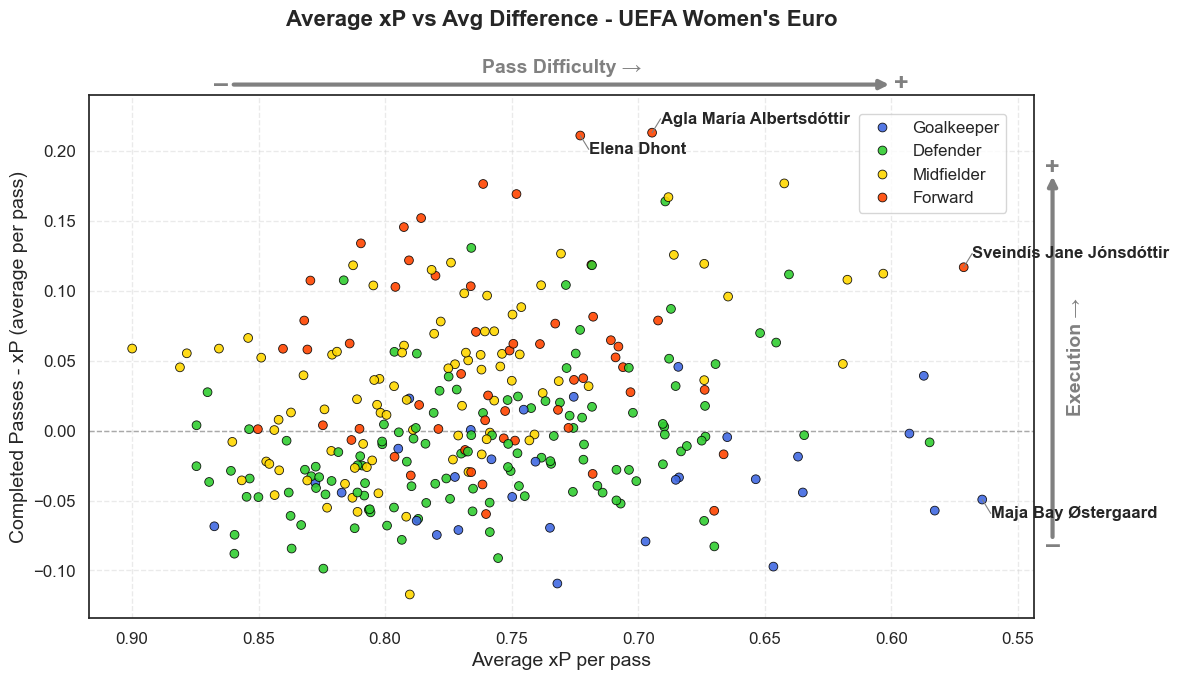

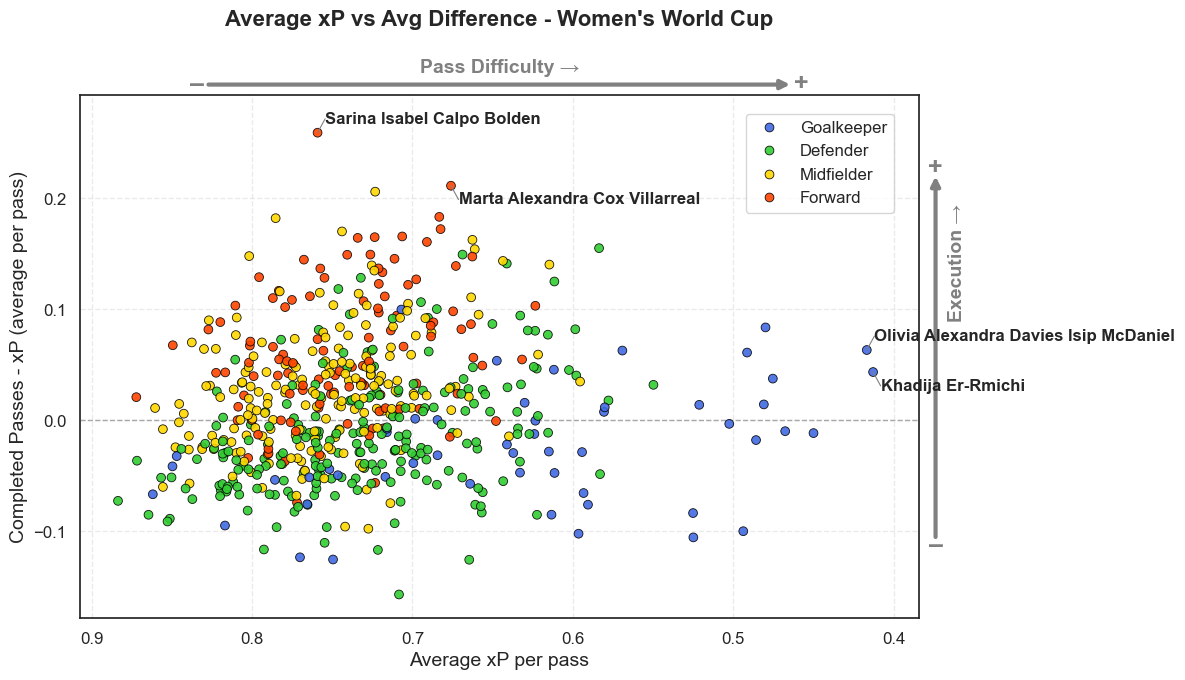

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.1)

MIN_PASSES = 50


def plot_xP_vs_diff_labels(df, title):
    df_plot = df[df['num_passes'] >= MIN_PASSES].reset_index(drop=True)
    
    position_order = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']
    
    df_plot['primary_main_position'] = pd.Categorical(
        df_plot['primary_main_position'],
        categories=position_order,
        ordered=True
    )

    position_palette = {
        'Goalkeeper': 'royalblue', 
        'Defender':   'limegreen',  
        'Midfielder': 'gold',   
        'Forward':    'orangered',   
    }
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.scatterplot(
        data=df_plot,
        x='avg_xP',
        y='avg_xP_difference',
        hue='primary_main_position',
        palette=position_palette,
        s=40,
        alpha=0.9,
        edgecolor='black',
        linewidth=0.6,
        ax=ax,
        zorder=3
    )
    
    ax.axhline(0, color='darkgray', linestyle='--', linewidth=1, zorder=1)


    # SELECT PLAYERS TO LABEL

    most_difficult = df_plot.nsmallest(2, 'avg_xP')
    best_execution = df_plot.nlargest(2, 'avg_xP_difference')

    label_players = (
        pd.concat([most_difficult, best_execution])
        .drop_duplicates(subset='player')
        .reset_index(drop=True)
    )


    # LABEL PLAYERS

    player_texts = []

    x_range = df_plot['avg_xP'].max() - df_plot['avg_xP'].min()
    y_range = df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min()

    # down, up, up, down
    vertical_pattern = [-0.03, 0.03, 0.03, -0.03]

    for i, (_, row) in enumerate(label_players.iterrows()):
        
        x_offset = 0.01 * x_range       # horizontal offset
        y_offset = vertical_pattern[i % 4] * y_range
        
        # because x-axis is inverted, subtracting moves label visually right
        x_text = row['avg_xP'] - x_offset
        y_text = row['avg_xP_difference'] + y_offset

        ax.plot(
            [row['avg_xP'], x_text],
            [row['avg_xP_difference'], y_text],
            color='gray',
            lw=0.8,
            zorder=4
        )

        txt = ax.text(
            x_text, y_text, row['player'],
            fontsize=12,
            weight='bold',
            va='center',
            ha='left',
            zorder=5
        )
        player_texts.append(txt)


    # AXIS + ARROWS

    ax.invert_xaxis()

    arrow_color = 'gray'

    # difficulty arrow (top)
    ax.annotate(
        '', xy=(0.85, 1.02), xytext=(0.15, 1.02),
        xycoords='axes fraction',
        arrowprops=dict(arrowstyle='-|>', lw=3, color=arrow_color),
        zorder=0,
        clip_on=False
    )

    ax.text(0.5, 1.035, 'Pass Difficulty →',
            transform=ax.transAxes,
            ha='center', va='bottom',
            fontsize=14, color=arrow_color, weight='bold')

    ax.text(0.14, 1.02, '–', transform=ax.transAxes,
            ha='center', va='center', fontsize=18,
            color=arrow_color, weight='bold')

    ax.text(0.86, 1.02, '+', transform=ax.transAxes,
            ha='center', va='center', fontsize=18,
            color=arrow_color, weight='bold')

    # execution arrow (right)
    ax.annotate(
        '', xy=(1.02, 0.85), xytext=(1.02, 0.15),
        xycoords='axes fraction',
        arrowprops=dict(arrowstyle='-|>', lw=3, color=arrow_color),
        zorder=0,
        clip_on=False
    )

    exec_label = ax.text(
        1.035, 0.5, 'Execution →',
        transform=ax.transAxes,
        rotation=90,
        ha='left', va='center',
        fontsize=14, color=arrow_color, weight='bold'
    )

    ax.text(1.02, 0.14, '–', transform=ax.transAxes,
            ha='center', va='center', fontsize=18,
            color=arrow_color, weight='bold')

    ax.text(1.02, 0.86, '+', transform=ax.transAxes,
            ha='center', va='center', fontsize=18,
            color=arrow_color, weight='bold')


    # SHIFT EXECUTION LABEL IF OVERLAPS


    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    def overlaps(text1, text2):
        return text1.get_window_extent(renderer).overlaps(
               text2.get_window_extent(renderer))

    shift = 0
    max_shift = 0.2

    while any(overlaps(exec_label, t) for t in player_texts) and shift < max_shift:
        shift += 0.02
        exec_label.set_position((1.035, 0.5 + shift))
        fig.canvas.draw()


    # TITLES + LEGEND


    ax.set_title(title, fontsize=16, weight='bold', pad=50)
    ax.set_xlabel('Average xP per pass', fontsize=14)
    ax.set_ylabel('Completed Passes - xP (average per pass)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.4)

    ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

    plt.tight_layout()
    plt.show()


# UEFA Women's Euro
plot_xP_vs_diff_labels(
    player_stats_euros,
    "Average xP vs Avg Difference - UEFA Women's Euro"
)

# Women's World Cup
plot_xP_vs_diff_labels(
    player_stats_worldcup,
    "Average xP vs Avg Difference - Women's World Cup"
)

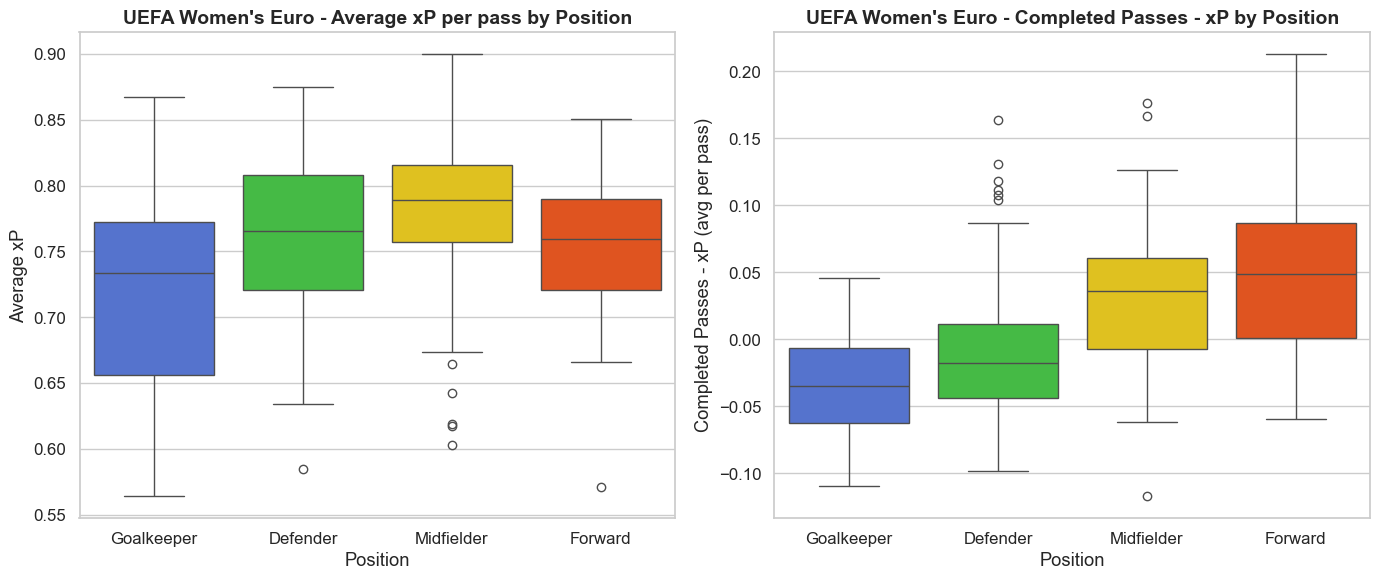

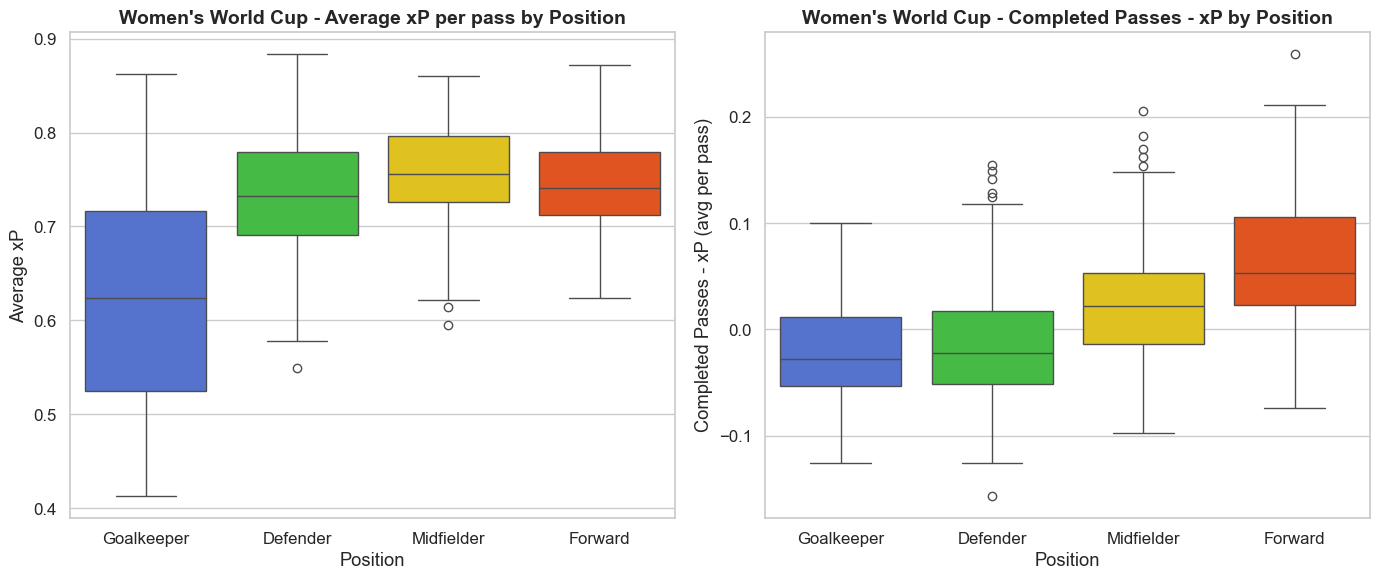

In [28]:
sns.set(style="whitegrid", font_scale=1.1)

MIN_PASSES = 50

position_palette = {
    'Goalkeeper': 'royalblue', 
    'Defender':   'limegreen',  
    'Midfielder': 'gold',   
    'Forward':    'orangered',   
}

def plot_xP_and_diff_per_position(df, title_prefix):
    """
    Plot boxplots of avg_xP and avg_xP_difference per primary position.
    """
    
    df_plot = df[df['num_passes'] >= MIN_PASSES].copy()
    
    position_order = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']
    
    df_plot['primary_main_position'] = pd.Categorical(
        df_plot['primary_main_position'],
        categories=position_order,
        ordered=True
    )
    
    plt.figure(figsize=(14, 6))
    
    # -------- avg_xP --------
    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=df_plot,
        x='primary_main_position',
        y='avg_xP',
        hue='primary_main_position',   # ⭐ required in new seaborn
        order=position_order,
        palette=position_palette,
        legend=False                   # ⭐ prevents duplicate legend
    )
    plt.title(f'{title_prefix} - Average xP per pass by Position', fontsize=14, weight='bold')
    plt.xlabel('Position')
    plt.ylabel('Average xP')
    
    # -------- avg_xP_difference --------
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df_plot,
        x='primary_main_position',
        y='avg_xP_difference',
        hue='primary_main_position',   # ⭐ required
        order=position_order,
        palette=position_palette,
        legend=False
    )
    plt.title(f'{title_prefix} - Completed Passes - xP by Position', fontsize=14, weight='bold')
    plt.xlabel('Position')
    plt.ylabel('Completed Passes - xP (avg per pass)')
    
    plt.tight_layout()
    plt.show()


# UEFA Women's Euro
plot_xP_and_diff_per_position(player_stats_euros, "UEFA Women's Euro")

# Women's World Cup
plot_xP_and_diff_per_position(player_stats_worldcup, "Women's World Cup")

# 6. Analyse goalkeepers' passes to understand their difficulty

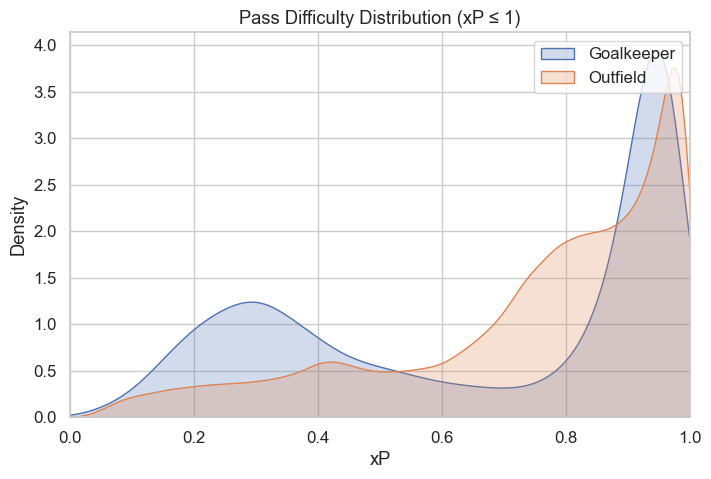

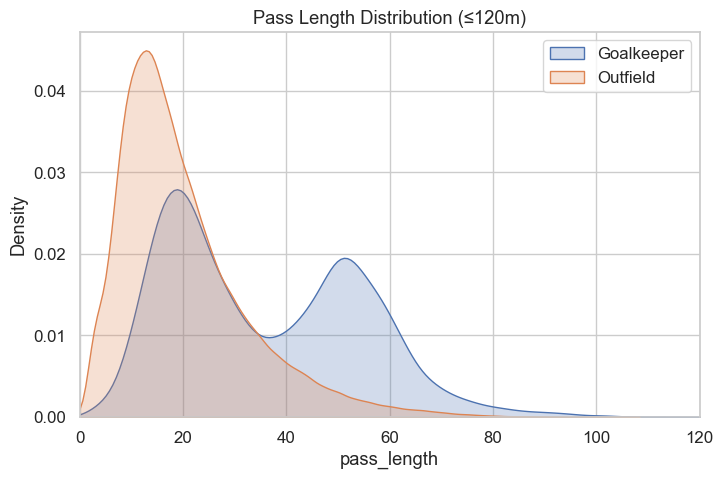

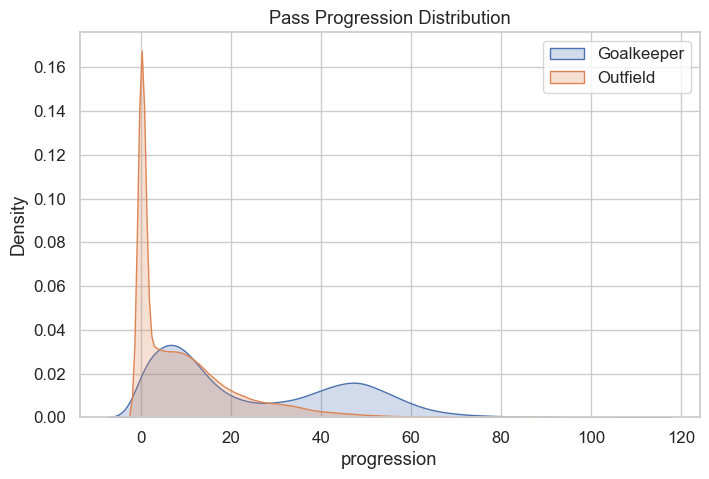


===== EUROS =====


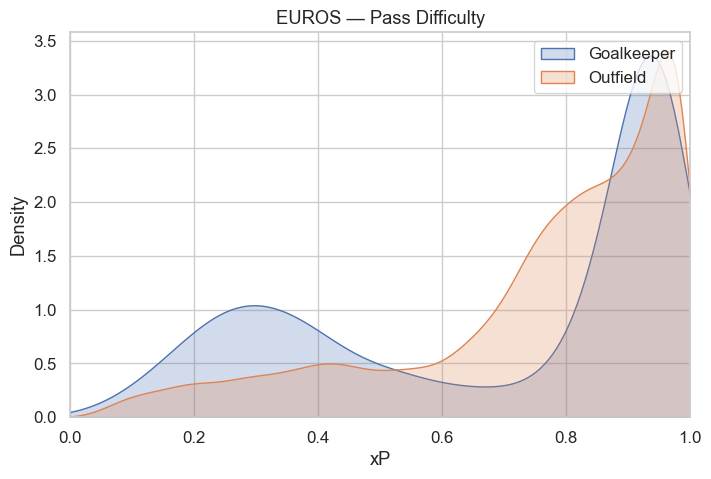

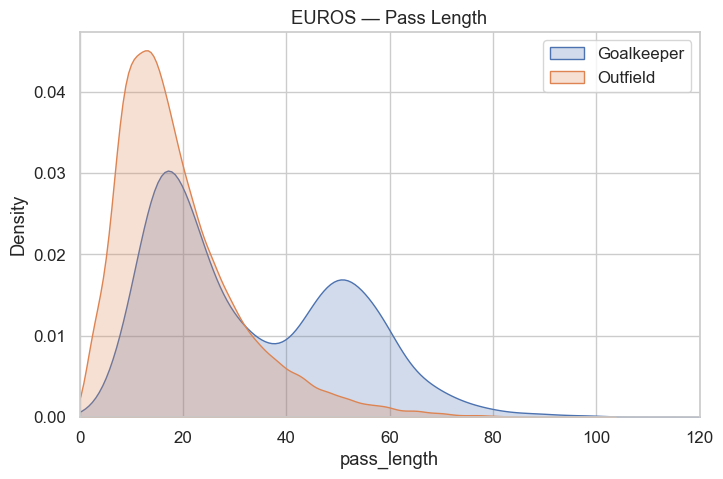

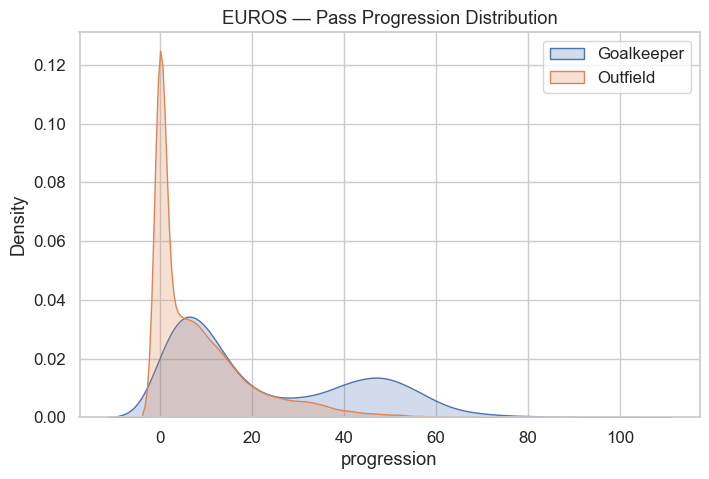


===== WORLD CUP =====


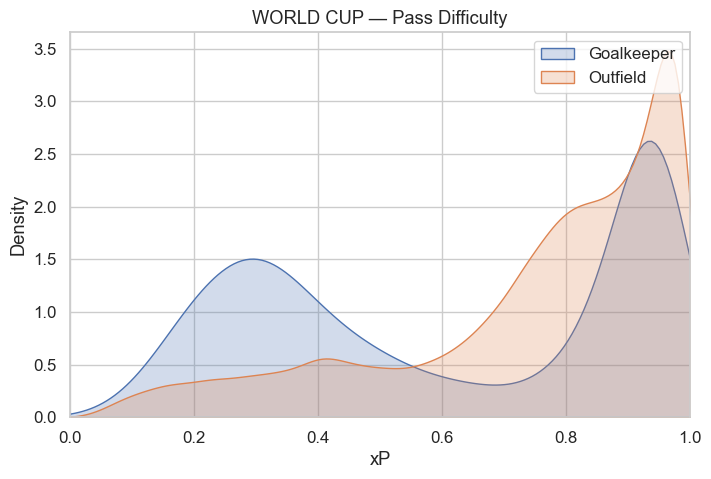

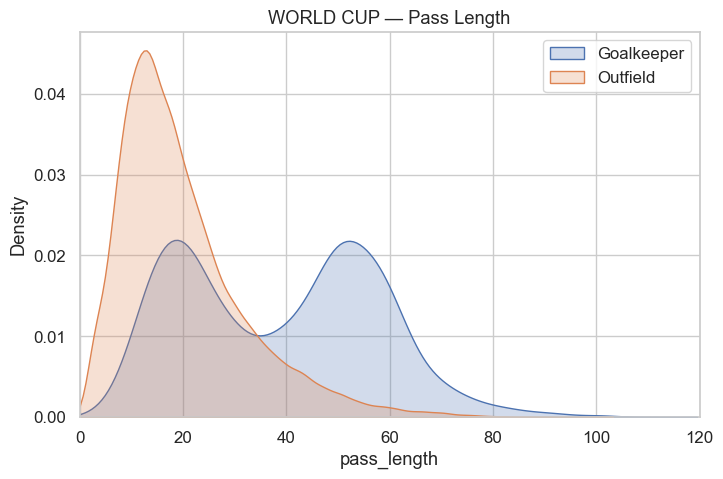

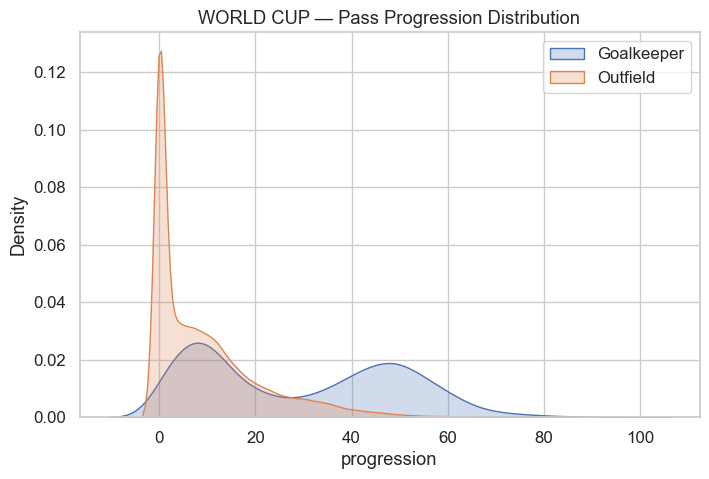


OVERALL SUMMARY


,mean_xP,median_xP,completion_rate,median_completion,mean_pass_length,median_pass_length,mean_progression,median_progression
Outfield,0.745,0.817,0.743,1.0,20.139,17.029,9.456,5.360
Goalkeeper,0.665,0.833,0.693,1.0,36.075,32.450,25.118,16.984



EUROS SUMMARY


,mean_xP,median_xP,completion_rate,median_completion,mean_pass_length,median_pass_length,mean_progression,median_progression
Outfield,0.757,0.828,0.770,1.0,19.269,16.348,8.622,4.597
Goalkeeper,0.694,0.877,0.754,1.0,33.392,27.856,22.976,14.198



WORLD CUP SUMMARY


,mean_xP,median_xP,completion_rate,median_completion,mean_pass_length,median_pass_length,mean_progression,median_progression
Outfield,0.747,0.820,0.750,1.0,19.889,16.992,9.305,5.271
Goalkeeper,0.612,0.614,0.648,1.0,38.952,40.564,29.423,28.790


In [30]:
# GOALKEEPER VS OUTFIELD PASS ANALYSIS (with progression)
# Uses: passes_xp_df + player_tournament_main_positions


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")


# 1. COPY PASSES DATA


passes = passes_xp_df.copy()


# 2. MERGE PLAYER PRIMARY POSITION


passes = passes.merge(
    player_tournament_main_positions[
        ['player', 'competition_name', 'primary_main_position']
    ],
    on=['player', 'competition_name'],
    how='left'
)


# 3. IDENTIFY GOALKEEPERS


passes["is_goalkeeper"] = passes["primary_main_position"] == "Goalkeeper"


# 4. CLEAN IMPOSSIBLE VALUES


# xP cannot exceed 1
passes = passes[passes["xP"] < 1].copy()
passes["xP"] = np.clip(passes["xP"], 0, 1)

# pass length cannot exceed pitch length
if "pass_length" in passes.columns:
    passes = passes[passes["pass_length"] <= 120].copy()
    passes["pass_length"] = np.clip(passes["pass_length"], 0, 120)

# progression cannot be negative (if exists)
if "progression" in passes.columns:
    passes["progression"] = np.clip(passes["progression"], 0, None)


# 5. SPLIT EUROS VS WORLD CUP


euros = passes[
    passes["competition_name"].str.contains("Euro", case=False, na=False)
].copy()

worlds = passes[
    passes["competition_name"].str.contains("World", case=False, na=False)
].copy()


# 6. KDE DENSITY FUNCTION


def plot_density(df, variable, title, xmax=None):

    plt.figure(figsize=(8,5))

    sns.kdeplot(
        df[df["is_goalkeeper"]][variable],
        label="Goalkeeper",
        fill=True,
        common_norm=False
    )

    sns.kdeplot(
        df[~df["is_goalkeeper"]][variable],
        label="Outfield",
        fill=True,
        common_norm=False
    )

    if xmax is not None:
        plt.xlim(0, xmax)

    plt.title(title)
    plt.xlabel(variable)
    plt.legend()
    plt.show()


# 7. OVERALL DISTRIBUTIONS


plot_density(passes, "xP", "Pass Difficulty Distribution (xP ≤ 1)", xmax=1)

if "pass_length" in passes.columns:
    plot_density(passes, "pass_length", "Pass Length Distribution (≤120m)", xmax=120)

if "progression" in passes.columns:
    plot_density(passes, "progression", "Pass Progression Distribution")


# 8. EUROS DISTRIBUTIONS


print("\n===== EUROS =====")

plot_density(euros, "xP", "EUROS — Pass Difficulty", xmax=1)

if "pass_length" in euros.columns:
    plot_density(euros, "pass_length", "EUROS — Pass Length", xmax=120)

if "progression" in euros.columns:
    plot_density(euros, "progression", "EUROS — Pass Progression Distribution")


# 9. WORLD CUP DISTRIBUTIONS


print("\n===== WORLD CUP =====")

plot_density(worlds, "xP", "WORLD CUP — Pass Difficulty", xmax=1)

if "pass_length" in worlds.columns:
    plot_density(worlds, "pass_length", "WORLD CUP — Pass Length", xmax=120)

if "progression" in worlds.columns:
    plot_density(worlds, "progression", "WORLD CUP — Pass Progression Distribution")


# 10. SUMMARY FUNCTION
# mean + median
# includes pass length + progression
# excludes pressure


def role_summary(df):

    summary = df.groupby("is_goalkeeper").agg(

        mean_xP=("xP", "mean"),
        median_xP=("xP", "median"),

        completion_rate=("completed", "mean"),
        median_completion=("completed", "median"),

        mean_pass_length=("pass_length", "mean"),
        median_pass_length=("pass_length", "median"),

        mean_progression=("progression", "mean"),
        median_progression=("progression", "median")
    )

    summary.index = ["Outfield", "Goalkeeper"]

    return summary.round(3)


# 11. FINAL SUMMARIES


print("\n==============================")
print("OVERALL SUMMARY")
print("==============================")
display(role_summary(passes))

print("\n==============================")
print("EUROS SUMMARY")
print("==============================")
display(role_summary(euros))

print("\n==============================")
print("WORLD CUP SUMMARY")
print("==============================")
display(role_summary(worlds))
